<a href="https://colab.research.google.com/github/Gio99c/BiSeNet/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import sys
#from google.colab import drive
#drive.mount('/content/drive')
#!git clone https://github.com/Gio99c/BiSeNet.git
#!pip install tensorboardX

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'BiSeNet'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 46 (delta 10), reused 36 (delta 7), pack-reused 0
Unpacking objects: 100% (46/46), done.
     |████████████████████████████████| 125 kB 5.3 MB/s 


In [3]:
#%cd /content/BiSeNet
#!python train.py

/content/BiSeNet
Import terminato
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100% 44.7M/44.7M [00:00<00:00, 142MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100% 171M/171M [00:01<00:00, 127MB/s]
epoch 0, lr 0.025000:   0% 0/504 [00:00<?, ?it/s]Traceback (most recent call last):
  File "train.py", line 273, in <module>
    main(params)
  File "train.py", line 254, in main
    train(args, model, optimizer, dataloader_train, dataloader_val)
  File "train.py", line 153, in train
    output, output_sup1, output_sup2 = model(data) #final_output, output_x16down, output_(x32down*tail)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/parallel/data_parallel.py", line

##### Extraction of info from the json file

In [2]:
import json
 
# Opening JSON file
f = open('./data/Cityscapes/info.json')
 
# returns JSON object as
# a dictionary
data = json.load(f)

In [11]:
label2train = data['label2train']
label2train_dict = {el[0]:el[1] for el in label2train }
label2train_dict

[[0, 255],
 [1, 255],
 [2, 255],
 [3, 255],
 [4, 255],
 [5, 255],
 [6, 255],
 [7, 0],
 [8, 1],
 [9, 255],
 [10, 255],
 [11, 2],
 [12, 3],
 [13, 4],
 [14, 255],
 [15, 255],
 [16, 255],
 [17, 5],
 [18, 255],
 [19, 6],
 [20, 7],
 [21, 8],
 [22, 9],
 [23, 10],
 [24, 11],
 [25, 12],
 [26, 13],
 [27, 14],
 [28, 15],
 [29, 255],
 [30, 255],
 [31, 16],
 [32, 17],
 [33, 18],
 [-1, 255]]

##### Prepare the paths

In [13]:
#Get the labels images
import numpy as np
from pathlib import Path

labels_paths = []
labels_list = np.array(sorted(Path('data\Cityscapes\labels').glob("*")))
train_samples = [l.split("/")[1] for l in np.loadtxt(f"data/Cityscapes/train.txt", dtype="unicode")]

for img in labels_list:
    modified_label = str(img).split("\\")[-1].replace("_gtFine_labelIds.png", "_leftImg8bit.png") #the replace operation is needed beacuse labels file have different names wrt the images    
    if modified_label in train_samples:
        labels_paths.append(str(img))

[WindowsPath('data/Cityscapes/labels/aachen_000001_000019_gtFine_labelIds.png')
 WindowsPath('data/Cityscapes/labels/aachen_000002_000019_gtFine_labelIds.png')
 WindowsPath('data/Cityscapes/labels/aachen_000004_000019_gtFine_labelIds.png')
 WindowsPath('data/Cityscapes/labels/aachen_000009_000019_gtFine_labelIds.png')
 WindowsPath('data/Cityscapes/labels/aachen_000012_000019_gtFine_labelIds.png')]
['strasbourg_000000_017593_leftImg8bit.png', 'zurich_000066_000019_leftImg8bit.png', 'hanover_000000_032681_leftImg8bit.png', 'ulm_000066_000019_leftImg8bit.png', 'dusseldorf_000006_000019_leftImg8bit.png']


In [39]:
def map(image, label2train):
    """
    image: matrix to map
    label2train: dictionary indicating the mapping
    """
    new_image = image.copy()
    for i in range(new_image.shape[0]):
        for j in range(new_image.shape[1]):
            new_image[i,j] = label2train_dict[new_image[i][j]]
    return new_image
   

#### Map function and test

In [42]:
#Map test
np.random.seed(1)
img = np.random.randint(-1,34, size=(5,5))
new_image = map(img, label2train_dict)
new_image

array([[  2,   0,   1, 255, 255],
       [255, 255, 255, 255,   2],
       [255, 255,  11,   6,   5],
       [  6, 255,  14,  15,   4],
       [255,   9,   9, 255,  16]])

In [48]:
from PIL import Image
img = Image.open(labels_paths[0])
new_img = map(np.array(img), label2train_dict)

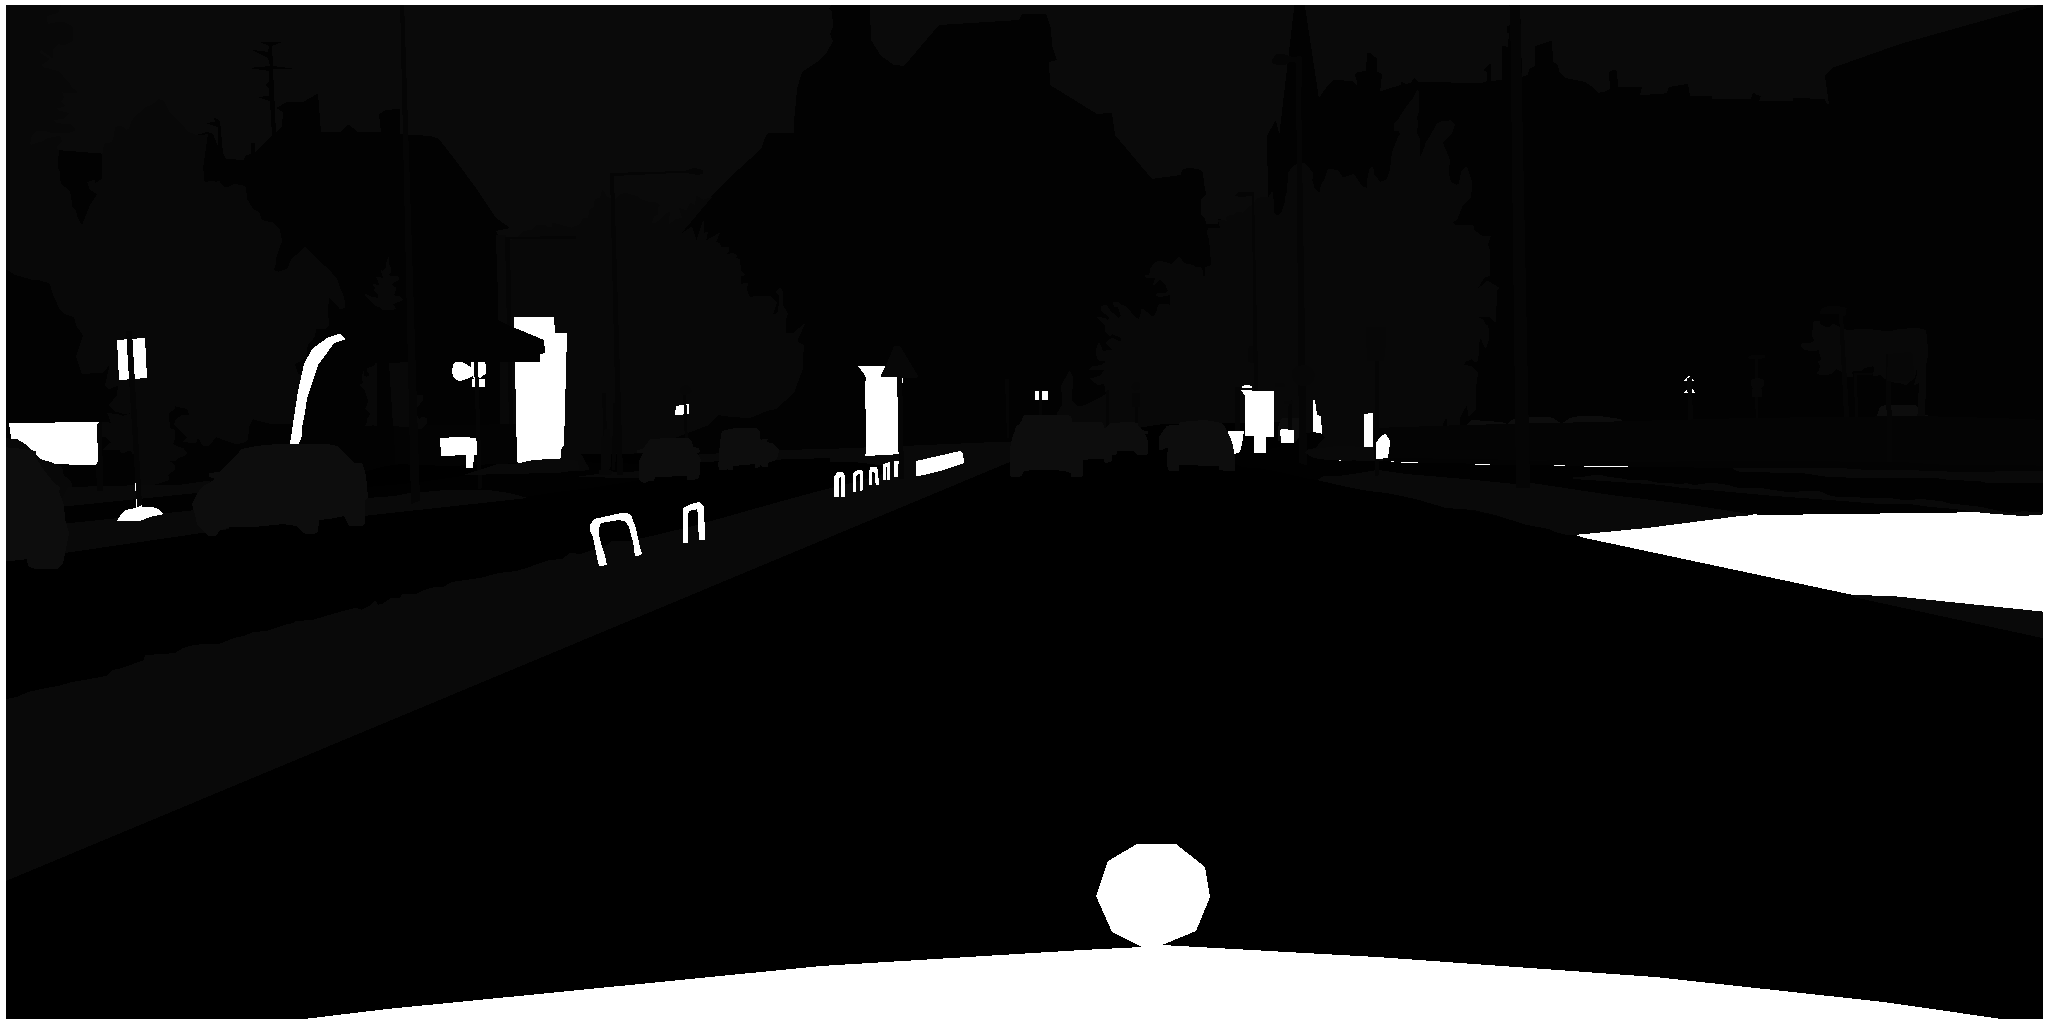

In [59]:
import torchvision
toPil = torchvision.transforms.ToPILImage(mode=None)
l = toPil(new_img)
l

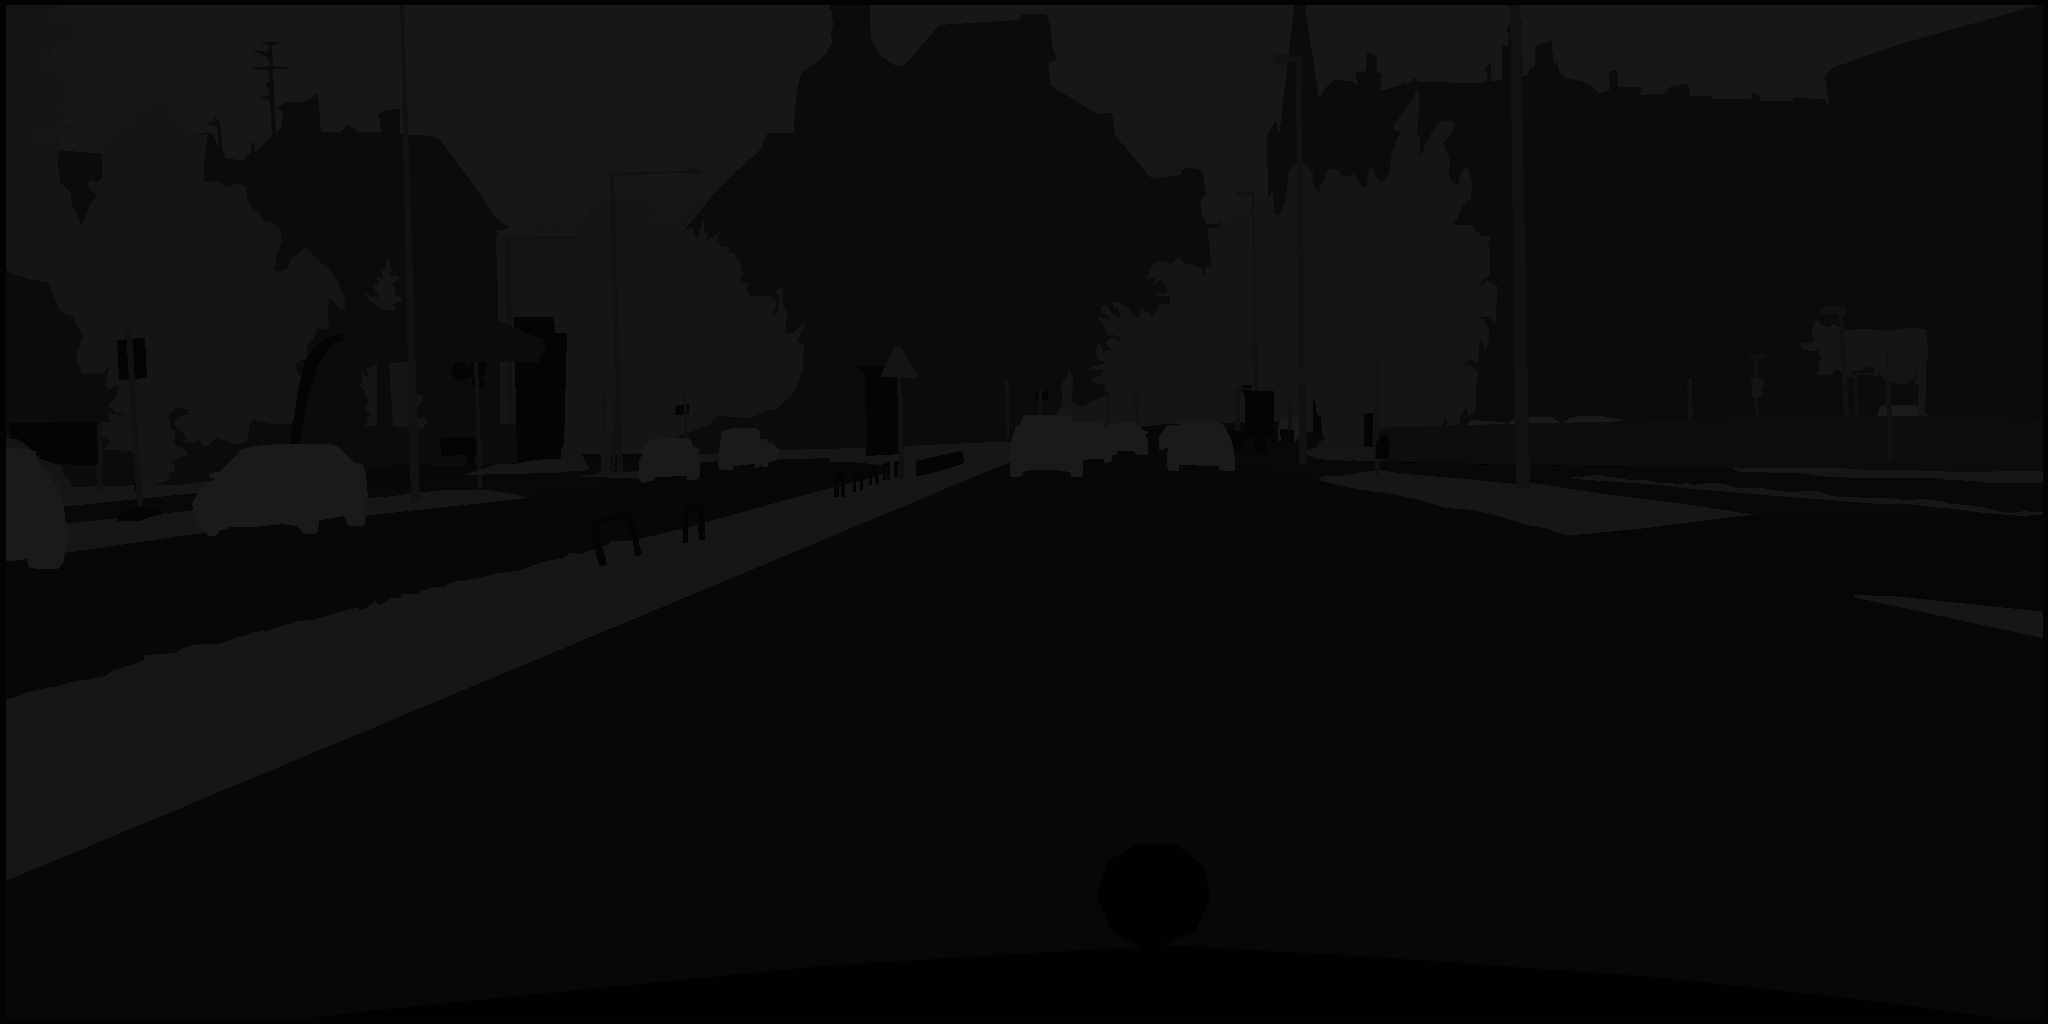

In [60]:
img

#### Map the labels

In [61]:
converted_labels = []
for img_path in labels_paths:
    img = Image.open(img_path)
    new_img = map(np.array(img), label2train_dict)
    converted_labels.append(new_img)

len(converted_labels)

500

Save the modified labels in a folder

In [103]:
for i, conv_label in enumerate(converted_labels):
    l_path = labels_paths[i].replace("labels", "modified_labels")
    im = Image.fromarray(conv_label)
    l_path = Path(l_path)
    im.save(l_path)
    
